In [1]:
import sys
sys.path.insert(0, "/home/hltcoe/estengel/miso_research/")
from miso.metrics.conllu import load_conllu
from collections import defaultdict

In [2]:
class AttachmentScoreCounter:
    def __init__(self):
        self.total = 0
        self.correct_head = 0
        self.correct_label = 0
        
    def __call__(self, true_head, pred_head, true_deprel, pred_deprel):
        self.total += 1
        if true_head == pred_head:
            self.correct_head += 1
        if true_deprel == pred_deprel:
            self.correct_label += 1
    
    def get_uas(self):
        return self.correct_head / self.total
    
    def get_las(self):
        return self.correct_label / self.total

def per_type_accuracy(true_file, pred_file, normalize_by_total = False):
    with open(true_file) as tf, open(pred_file) as pf:
        true_data = load_conllu(tf)
        pred_data = load_conllu(pf)
    assert(len(true_data.words) == len(pred_data.words))
    
    per_deprel_counters = defaultdict(lambda: AttachmentScoreCounter())
    
    for tw, pw in zip(true_data.words, pred_data.words):
        assert(tw.columns[0] == pw.columns[0])
        
        if tw.parent is None:
            assert(tw.columns[7] == "root")
            true_parent_idx = tw.columns[6]
        if pw.parent is None:
#             assert(pw.columns[7] == "root")
            pred_parent_idx = pw.columns[6]
    
        if tw.parent is not None and pw.parent is not None:  
            true_parent_idx = tw.parent.columns[0]
            pred_parent_idx = pw.parent.columns[0]
            
        true_deprel = tw.columns[7]
        pred_deprel = pw.columns[7]
        
        per_deprel_counters[true_deprel](true_parent_idx, pred_parent_idx, true_deprel, pred_deprel)
        
    per_deprel_uas = {k:v.get_uas() for k, v in per_deprel_counters.items()}
    per_deprel_las = {k:v.get_las() for k, v in per_deprel_counters.items()}
    
    totals = {k: v.total for k, v in per_deprel_counters.items()}
    if normalize_by_total:
        total_total = sum(totals.values())
        percentages = {k: v/total_total for k,v in totals.items()}
        per_deprel_uas = {k: v * percentages[k] for k, v in per_deprel_uas.items()}
        per_deprel_las = {k: v * percentages[k] for k, v in per_deprel_las.items()}
        
    return per_deprel_uas, per_deprel_las, totals
        
        

In [3]:
gold_ud_path = "/home/hltcoe/estengel/glavas_g_2020/data/EWT_clean/en-ud-dev.conllu"
uds_ud_path = "/exp/estengel/miso_res/transformer_bert_tune/layer_5/decomp_transformer_encoder_syn_opt_double/dev.conllu"
no_uds_ud_path = "/exp/estengel/miso_res/transformer_bert_tune/layer_5/decomp_syntax_only/dev.conllu"

uas_dict_with_uds, las_dict_with_uds, totals = per_type_accuracy(gold_ud_path, uds_ud_path, False)
uas_dict_no_uds, las_dict_no_uds, __ = per_type_accuracy(gold_ud_path, no_uds_ud_path, False)



In [4]:
from matplotlib import pyplot as plt 
import seaborn as sns 
import pandas as pd


def get_dataframes(uas_with_dict, uas_without_dict, las_with_dict, las_without_dict, totals, top_k=10, by_total = True):

    uas_deltas = {k: uas_with_dict[k] - uas_without_dict[k] for k in uas_with_dict.keys()}
    las_deltas = {k: las_with_dict[k] - las_without_dict[k] for k in las_with_dict.keys()}

    def trim_to_topk(data):
        # either take top k by total number of examples, 
        if by_total:
            sorted_data = sorted(data.items(), key=lambda x: totals[x[0]])[-top_k:]
        # or top k by absolute value of delta 
        else:
            sorted_data = sorted(data.items(), key=lambda x: abs(x[1]))[-top_k:]
        to_ret = {k: v for k,v in sorted_data}
        
        return to_ret

    # only look at K biggest by absolute value 
    uas_deltas = trim_to_topk(uas_deltas)
    las_deltas = trim_to_topk(las_deltas)

    uas_deltas_sorted = sorted(uas_deltas.items(), key=lambda x: totals[x[0]])
    las_deltas_sorted = sorted(las_deltas.items(), key=lambda x: totals[x[0]])


    uas_df = pd.DataFrame(uas_deltas_sorted, columns=["deprel", "delta"])
    las_df = pd.DataFrame(las_deltas_sorted, columns=["deprel", "delta"])
    return uas_df, las_df 



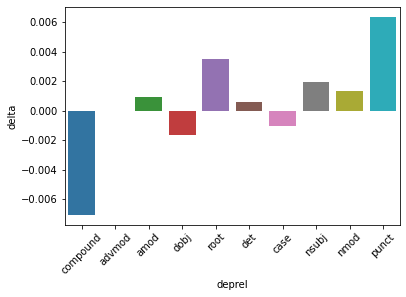

In [12]:
# UDS vs no UDS signal 
uas_df, las_df = get_dataframes(uas_dict_with_uds, uas_dict_no_uds, las_dict_with_uds, las_dict_no_uds, totals, by_total = True)


ax  = sns.barplot(x="deprel", y="delta", data=uas_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

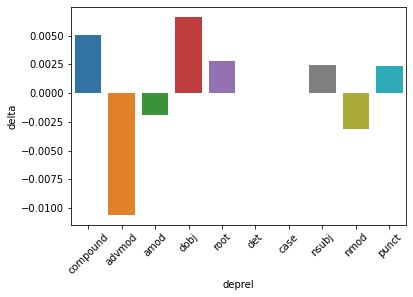

In [6]:
ax  = sns.barplot(x="deprel", y="delta", data=las_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

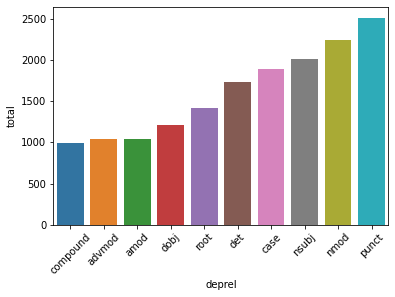

In [7]:
total_df = pd.DataFrame(sorted(totals.items(), key=lambda x:x[1])[-10:], columns=["deprel", "total"])

ax  = sns.barplot(x="deprel", y="total", data=total_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [8]:
gold_ud_path = "/home/hltcoe/estengel/glavas_g_2020/data/EWT_clean/en-ud-dev.conllu"
best_uds_ud_path = "/exp/estengel/miso_res/transformer_bert_tune/layer_5/decomp_transformer_encoder_syn_opt_double/dev.conllu"

uds_no_tune_path = "/exp/estengel/miso_res/transformer_fix/decomp_interface_encoder_syn_opt_double/dev.conllu"

uas_dict_with_tuning, las_dict_with_tuning, totals = per_type_accuracy(gold_ud_path, best_uds_ud_path, False)
uas_dict_no_tuning, las_dict_no_tuning, __ = per_type_accuracy(gold_ud_path, uds_no_tune_path, False)

uas_df, las_df = get_dataframes(uas_dict_with_tuning, uas_dict_no_tuning, las_dict_with_tuning, las_dict_no_tuning, totals, top_k = 10, by_total = True)

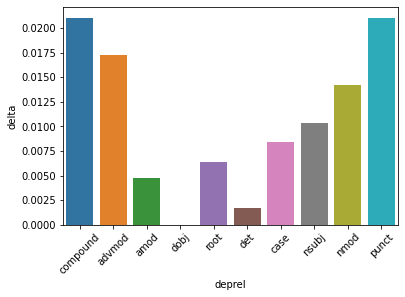

In [9]:
ax  = sns.barplot(x="deprel", y="delta", data=uas_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)

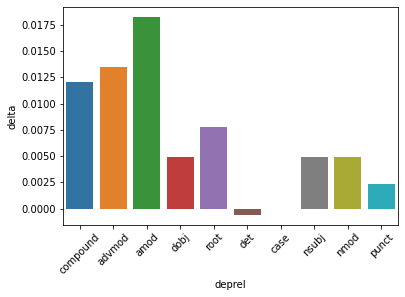

In [10]:
ax  = sns.barplot(x="deprel", y="delta", data=las_df)
for item in ax.get_xticklabels():
    item.set_rotation(45)